In [2]:
import os
import requests
import zipfile
import random
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch import nn
from torch.nn import CrossEntropyLoss
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from typing import Tuple, List, Dict

np.random.seed(42)
torch.manual_seed(42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
def data_setup(
    data_path: Path, 
    image_path: Path
): 
    # If data path doesn't exist, download and create one...
    if data_path.is_dir(): 
        print(f"{data_path}\ exists already.")
    else: 
        print(f"{data_path} does not exist, creating one.")
        data_path.mkdir(parents=True, exist_ok=True)
        
    # Same goes for image_path
    if image_path.is_dir(): 
        print(f"{image_path} already exists.")
    else: 
        print(f"{image_path} not found. Creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Using requests to download from link.
        with open(data_path / "pizza_steak_sushi.zip", "wb") as f: 
            request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
            print("Downloading pizza, steak, sushi data...")
            f.write(request.content)
            
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_file: 
            print("Unzipping...")
            zip_file.extractall(image_path)

In [5]:
data_path = Path("dataset/")
image_path = data_path / "FoodClass"

data_setup(data_path, image_path)

dataset does not exist, creating one.
dataset\FoodClass not found. Creating one...
Unzipping...


In [6]:
train_dir = image_path / "train" 
test_dir = image_path / "test"

train_dir

WindowsPath('dataset/FoodClass/train')

Random Image path: dataset\FoodClass\train\sushi\385154.jpg
Image class: sushi
Image dimensions: 382 x 512


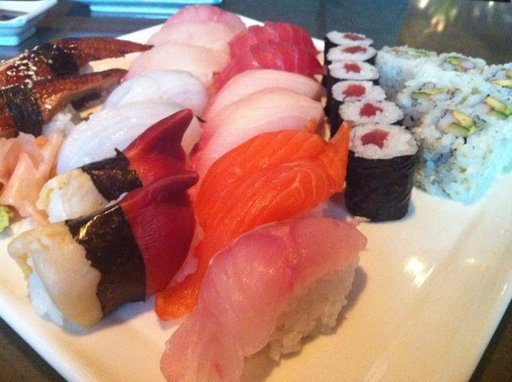

In [7]:
torch.manual_seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image = random.choice(image_path_list)
image_class = random_image.parent.stem
img = Image.open(random_image)

print(f"Random Image path: {random_image}")
print(f"Image class: {image_class}")
print(f"Image dimensions: {img.height} x {img.width}")
img

In [8]:
# Two things before turning this image data into usable data for our neural network. 
# 1. Convert images to tensors
# 2. Convert tensors to Dataset and Dataloader.

# Transformation: 
# a. Resize to 64x64
# b. Flip the image with a probability of 50%
# c. turn the image into a tensor()

transformation = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor()
])

In [9]:
# To visualize both the original and resized images.
"""
torch.manual_seed(42)
random.seed(42)
random_paths = random.sample(image_path_list, k=2)

for image_path in random_paths: 
    with Image.open(image_path) as file: 
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(file)
        ax[0].set_title(f"Original size: {file.size}")
        ax[0].axis("off")
        
        transformed_image = transformation(file).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Resized size: {transformed_image.size}")
        ax[1].axis("off")
        
        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)
"""

'\ntorch.manual_seed(42)\nrandom.seed(42)\nrandom_paths = random.sample(image_path_list, k=2)\n\nfor image_path in random_paths: \n    with Image.open(image_path) as file: \n        fig, ax = plt.subplots(1, 2)\n        ax[0].imshow(file)\n        ax[0].set_title(f"Original size: {file.size}")\n        ax[0].axis("off")\n        \n        transformed_image = transformation(file).permute(1, 2, 0)\n        ax[1].imshow(transformed_image)\n        ax[1].set_title(f"Resized size: {transformed_image.size}")\n        ax[1].axis("off")\n        \n        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)\n'

In [10]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes: 
        raise FileNotFoundError(f"Couldn't load any classes in {directory}")
        
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [11]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [12]:
class CreateDataset(Dataset): 
    def __init__(self, target_dir: str, transform=None) -> None: 
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)
        
    def load_image(self, index: int) -> Image.Image: 
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int: 
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]: 
        image = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform: 
            return self.transform(img), class_idx
        else: 
            return img, class_idx

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

train_data = CreateDataset(target_dir=train_dir, 
                          transform=train_transforms)

test_data = CreateDataset(target_dir=test_dir, 
                         transform=test_transforms)

train_data, test_data

(<__main__.CreateDataset at 0x230a4efb350>,
 <__main__.CreateDataset at 0x2309d580ad0>)

In [14]:
len(train_data), len(test_data)

(225, 75)

In [15]:
train_data.classes

['pizza', 'steak', 'sushi']

In [16]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=1, 
                             num_workers=0, 
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=1, 
                            num_workers=0, 
                            shuffle=False)

img_custom, label_custom = next(iter(train_dataloader))

print(f"Image shape: {img_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64])


In [18]:
# Time for our Vision Transformer

# 1. Patchifying our image to split it into multiple components
# 2. Linear mapping
# 3. Positional embedding

def patchify(images, n_patches): 
    n, c, h, w = images.shape
    
    assert h == w, "Only for square images" 
    
    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches
    
    for idx, image in enumerate(images): 
        for i in range(n_patches): 
            for j in range(n_patches): 
                patch = image[:, i * patch_size: (i+1) * patch_size, j * patch_size: (j+1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [19]:
class SampleViT(nn.Module): 
    def __init__(self, chw=(3, 64, 64), n_patches=16): 
        super(SampleViT, self).__init__()

        self.chw = chw
        self.n_patches = n_patches

        assert chw[1] % n_patches == 0
        assert chw[2] % n_patches == 0

    def forward(self, images): 
        patches = patchify(images, self.n_patches)
        return patches

In [20]:
model = SampleViT(
    chw=(3, 64, 64), 
    n_patches = 8
)

x = torch.randn(1, 3, 64, 64)
print(model(x).shape)

torch.Size([1, 64, 192])


In [21]:
def positional_embeddings(sequence_length, d): 
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length): 
        for j in range(d): 
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** (j / d)))
    return result

In [22]:
class MSA(nn.Module): 
    def __init__(self, d, n_heads=4):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        
        assert d % n_heads == 0 # Shouldn't divide dimension (d) into n_heads
        
        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, sequences): 
        result = []
        for sequence in sequences: 
            seq_result = []
            for head in range(self.n_heads): 
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                
                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)
                
                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [23]:
class Residual(nn.Module): 
    def __init__(self, hidden_d, n_heads, mlp_ratio=4): 
        super(Residual, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d), 
            nn.GELU(), 
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
        
    def forward(self, x): 
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [24]:
class ViT(nn.Module): 
    def __init__(self, chw, n_patches=16, n_blocks=2, hidden_d=8, n_heads=4, out_d=10): 
        super(ViT, self).__init__()
        
        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patch sizes
        assert chw[1] % n_patches == 0
        assert chw[2] % n_patches == 0
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        
        # Linear mapping
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # Classification token
        self.v_class = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # Positional embedding
        self.register_buffer('positional_embeddings', positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # Encoder blocks
        self.blocks = nn.ModuleList([MSA(hidden_d, n_heads) for _ in range(n_blocks)])

        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d), 
            nn.Softmax(dim=-1)
        )
    
    def forward(self, images): 
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # running tokenization
        tokens = self.linear_mapper(patches)
        tokens = torch.cat((self.v_class.expand(n, 1, -1), tokens), dim=1)
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        for block in self.blocks: 
            out = block(out)
            
            
        out = out[:, 0]
        return self.mlp(out)

Using MNIST for Image Classification

Our job is progressively easier here as we do not have to augment our images much. 

In [25]:
def main(): 
    # transform = ToTensor()
    # train_mnist = MNIST(root='./mnist', train=True, download=True, transform=transform)
    # test_mnist = MNIST(root='./mnist', train=False, download=True, transform=transform)

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mnist_model = ViT((3, 64, 64), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    epochs=8
    lr=0.005

    optimizer = Adam(mnist_model.parameters(), lr=lr)
    criterion = CrossEntropyLoss()
    for epoch in trange(epochs, desc="train"): 
        train_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False): 
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = mnist_model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_dataloader)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs} loss: {train_loss:.2f}")


    with torch.no_grad(): 
        correct, total = 0,0
        test_loss = 0.0
        for batch in tqdm(test_dataloader, desc="Testing"): 
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = mnist_model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_dataloader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)

        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [26]:
main()

Using device:  cuda (NVIDIA GeForce MX250)


train:   0%|          | 0/8 [00:06<?, ?it/s]                          


KeyboardInterrupt: 